In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [193]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')


In [194]:
train_df.head()

,participant_id,split,sex,age,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,100053248969,train,female,19.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,0
1,100263562592,train,male,21.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,1
2,100479214233,train,female,21.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,2
3,100544064116,train,female,15.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,4
4,101404752059,train,male,31.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,1


In [195]:
test_df.head()

,participant_id,split,sex,age,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,100536464191,internal_test,male,27.0,control,1387.098050,239.146911,657.741107,489.637289,3.0,1.0,3
1,101428024622,internal_test,female,37.0,control,1468.823686,316.712584,647.173235,503.982137,3.0,1.0,5
2,106422294651,internal_test,male,21.0,control,1444.957671,232.314985,687.272175,524.555645,3.0,1.0,3
3,107989352584,internal_test,female,38.0,control,1234.336318,205.397075,595.299439,433.157145,3.0,1.0,0
4,111128623875,internal_test,female,21.0,control,1326.123721,170.809164,652.766914,501.979176,3.0,1.0,25


In [196]:
train_df.isnull().sum()

participant_id             0
split                      0
sex                        0
age                        0
diagnosis                  0
tiv                        0
csfv                       0
gmv                        0
wmv                        0
magnetic_field_strength    0
acquisition_setting        0
site                       0
dtype: int64

In [197]:
test_df.isnull().sum()

participant_id             0
split                      0
sex                        0
age                        0
diagnosis                  0
tiv                        0
csfv                       0
gmv                        0
wmv                        0
magnetic_field_strength    0
acquisition_setting        0
site                       0
dtype: int64

In [198]:
train_df.describe()

,participant_id,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
count,3.227000e+03,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,5.528100e+11,25.189897,1450.308366,255.351875,683.223067,510.775905,2.878215,1.235203,17.014874
std,2.601096e+11,14.610795,143.447414,61.526835,88.802031,62.197406,0.409753,0.523023,16.363616
min,1.000532e+11,6.000000,762.709988,114.744980,260.969929,313.087018,1.500000,1.000000,0.000000
25%,3.294816e+11,19.000000,1347.441604,213.241928,628.054018,466.901853,3.000000,1.000000,3.000000
50%,5.454653e+11,21.000000,1446.419788,244.721740,683.143569,506.775548,3.000000,1.000000,11.000000
75%,7.808663e+11,26.000000,1548.835040,284.913100,740.928422,551.957164,3.000000,1.000000,25.000000
max,9.998326e+11,86.198494,2101.970447,624.906527,986.262878,808.156251,3.000000,3.000000,63.000000


In [199]:
test_df.describe()

,participant_id,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
count,7.570000e+02,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000
mean,5.602324e+11,23.782039,1449.927165,243.227897,693.407829,512.356327,2.831572,1.087186,21.606341
std,2.624066e+11,12.764675,146.694673,63.410481,84.398728,63.843479,0.473889,0.321714,17.790473
min,1.005365e+11,5.900000,1007.342489,100.219412,450.753039,359.812997,1.500000,1.000000,0.000000
25%,3.350397e+11,18.000000,1351.161698,202.587749,634.058860,466.391550,3.000000,1.000000,12.000000
50%,5.614491e+11,21.000000,1438.947924,239.211893,691.833610,509.634727,3.000000,1.000000,15.000000
75%,7.953016e+11,26.000000,1543.050467,277.473453,746.973051,553.566346,3.000000,1.000000,31.000000
max,9.986211e+11,88.000000,1898.660765,531.819252,914.180239,762.610161,3.000000,3.000000,63.000000


In [200]:
for col in train_df.columns:
    print(f"Column: {col}")
    print(train_df[col].value_counts())
    print("\n")


Column: participant_id
participant_id
999832619027    1
100053248969    1
100263562592    1
100479214233    1
100544064116    1
               ..
109712998508    1
109861838866    1
110463604078    1
110513034050    1
110519368768    1
Name: count, Length: 3227, dtype: int64


Column: split
split
train    3227
Name: count, dtype: int64


Column: sex
sex
male      1669
female    1558
Name: count, dtype: int64


Column: age
age
21.000000    493
19.000000    477
23.000000    247
25.000000    119
22.500000     80
            ... 
27.900000      1
10.840000      1
66.275154      1
8.430000       1
52.531143      1
Name: count, Length: 913, dtype: int64


Column: diagnosis
diagnosis
control    3227
Name: count, dtype: int64


Column: tiv
tiv
1480.964165    2
1363.567619    2
1379.618026    1
1646.501644    1
1519.294080    1
              ..
1364.168106    1
1375.614687    1
1458.147192    1
1270.623582    1
1643.530659    1
Name: count, Length: 3225, dtype: int64


Column: csfv
csfv
194.381

In [201]:
for col in test_df.columns:
    print(f"Column: {col}")
    print(test_df[col].value_counts())
    print("\n")

Column: participant_id
participant_id
998587653727    1
100536464191    1
101428024622    1
106422294651    1
107989352584    1
               ..
164278388741    1
165494760529    1
167117669616    1
171261643379    1
172422521939    1
Name: count, Length: 757, dtype: int64


Column: split
split
external_test    395
internal_test    362
Name: count, dtype: int64


Column: sex
sex
male      418
female    339
Name: count, dtype: int64


Column: age
age
19.000000    88
21.000000    85
23.000000    35
20.000000    33
22.000000    25
             ..
14.300000     1
11.758904     1
39.036277     1
73.000000     1
11.300000     1
Name: count, Length: 339, dtype: int64


Column: diagnosis
diagnosis
control    757
Name: count, dtype: int64


Column: tiv
tiv
1584.481992    1
1387.098050    1
1468.823686    1
1444.957671    1
1234.336318    1
              ..
1561.828582    1
1492.263648    1
1434.337918    1
1688.161502    1
1381.158480    1
Name: count, Length: 757, dtype: int64


Column: csfv


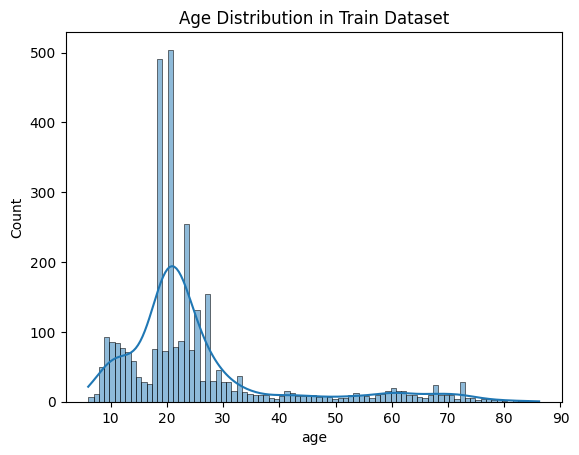

In [202]:
sns.histplot(train_df['age'], kde=True)
plt.title('Age Distribution in Train Dataset')
plt.show()

In [203]:
columns_to_drop = ['participant_id', 'split', 'diagnosis']
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

In [204]:
train_df.head()

,sex,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,female,19.0,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,0
1,male,21.0,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,1
2,female,21.0,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,2
3,female,15.0,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,4
4,male,31.0,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,1


In [205]:
test_df.head()

,sex,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,male,27.0,1387.098050,239.146911,657.741107,489.637289,3.0,1.0,3
1,female,37.0,1468.823686,316.712584,647.173235,503.982137,3.0,1.0,5
2,male,21.0,1444.957671,232.314985,687.272175,524.555645,3.0,1.0,3
3,female,38.0,1234.336318,205.397075,595.299439,433.157145,3.0,1.0,0
4,female,21.0,1326.123721,170.809164,652.766914,501.979176,3.0,1.0,25


In [206]:
label_encoder = LabelEncoder()
train_df['sex'] = label_encoder.fit_transform(train_df['sex'])
test_df['sex'] = label_encoder.transform(test_df['sex'])

In [207]:
train_df.head()

,sex,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,0,19.0,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,0
1,1,21.0,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,1
2,0,21.0,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,2
3,0,15.0,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,4
4,1,31.0,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,1


In [208]:
test_df.head()

,sex,age,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,1,27.0,1387.098050,239.146911,657.741107,489.637289,3.0,1.0,3
1,0,37.0,1468.823686,316.712584,647.173235,503.982137,3.0,1.0,5
2,1,21.0,1444.957671,232.314985,687.272175,524.555645,3.0,1.0,3
3,0,38.0,1234.336318,205.397075,595.299439,433.157145,3.0,1.0,0
4,0,21.0,1326.123721,170.809164,652.766914,501.979176,3.0,1.0,25


In [209]:
X_train = train_df.drop(columns=['age'])
y_train = train_df['age']

In [210]:
X_test = test_df.drop(columns=['age'])
y_test = test_df['age'] 

In [211]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [212]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3227, 8)
X_test shape: (757, 8)
y_train shape: (3227,)
y_test shape: (757,)
